In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
esquema = engine.execute("PRAGMA table_info(measurement)")
for x in esquema:
    print(x)

(0, 'id', 'INTEGER', 1, None, 1)
(1, 'station', 'TEXT', 0, None, 0)
(2, 'date', 'TEXT', 0, None, 0)
(3, 'prcp', 'FLOAT', 0, None, 0)
(4, 'tobs', 'FLOAT', 0, None, 0)


In [11]:
esquema = engine.execute("PRAGMA table_info(station)")
for x in esquema:
    print(x)

(0, 'id', 'INTEGER', 1, None, 1)
(1, 'station', 'TEXT', 0, None, 0)
(2, 'name', 'TEXT', 0, None, 0)
(3, 'latitude', 'FLOAT', 0, None, 0)
(4, 'longitude', 'FLOAT', 0, None, 0)
(5, 'elevation', 'FLOAT', 0, None, 0)


In [12]:
#Borramos los registros que no contengan informacion de prcp
session.query(Measurement).filter(Measurement.prcp==None).delete()

1447

# Exploratory Climate Analysis

(0, 2)

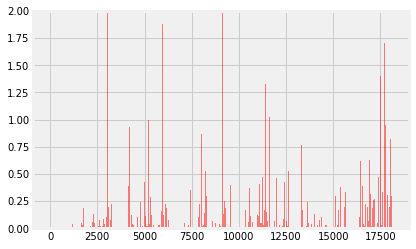

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
session.query(Measurement.date,Measurement.prcp).all()
df1=pd.DataFrame(session.query(Measurement.date,Measurement.prcp).all())
y=df1.loc[:,'prcp']
x=np.arange(len(y))
l=df1.loc[:,'date']
plt.bar(x,y,color='r', alpha=0.5)
plt.ylim(0, 2)

In [14]:
ult=df1.loc[len(x)-1,'date']
ult

'2017-08-23'

In [15]:
# Calculate the date 1 year ago from the last data point in the database
dt.date(2017,8,23) - dt.timedelta(days=365)

datetime.date(2016, 8, 23)

In [16]:
# Perform a query to retrieve the data and precipitation scores
session.query(Measurement.id,Measurement.station,Measurement.date,Measurement.prcp,Measurement.tobs).all()
# Save the query results as a Pandas DataFrame and set the index to the date column
data = pd.DataFrame(session.query(Measurement.id,Measurement.station,Measurement.date,Measurement.prcp,Measurement.tobs).all())
data=data.set_index('date')
# Sort the dataframe by date
data.head()

,id,station,prcp,tobs
date,,,,
2010-01-01,1,USC00519397,0.08,65.0
2010-01-02,2,USC00519397,0.00,63.0
2010-01-03,3,USC00519397,0.00,74.0
2010-01-04,4,USC00519397,0.00,76.0
2010-01-07,6,USC00519397,0.06,70.0


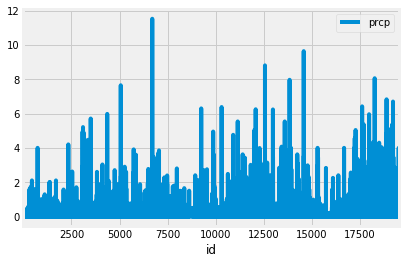

In [17]:
# Use Pandas Plotting with Matplotlib to plot the data
ax = plt.gca()
data.plot(kind='line',x='id',y='prcp',ax=ax)

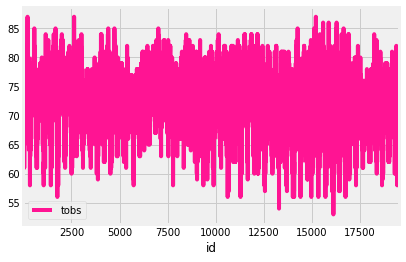

In [18]:
ax = plt.gca()
data.plot(kind='line',x='id',y='tobs',color='deeppink',ax=ax)

![precipitation](Images/precipitation.png)

In [19]:
# Use Pandas to calcualte the summary statistics for the precipitation data
data.describe()['prcp']

count    18103.000000
mean         0.160644
std          0.468746
min          0.000000
25%          0.000000
50%          0.010000
75%          0.110000
max         11.530000
Name: prcp, dtype: float64

![describe](Images/describe.png)

In [20]:
# Design a query to show how many stations are available in this dataset?
session.query(Station).count()

9

In [21]:
datsta= pd.DataFrame(session.query(Station.id, Station.station,Station.name, Station.latitude, Station.longitude, Station.elevation).all())
datsta.head()

,id,station,name,latitude,longitude,elevation
0,1,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
1,2,USC00513117,"KANEOHE 838.1, HI US",21.4234,-157.8015,14.6
2,3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.5213,-157.8374,7.0
3,4,USC00517948,"PEARL CITY, HI US",21.3934,-157.9751,11.9
4,5,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.4992,-158.0111,306.6


In [22]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
session.query(Measurement.station,func.count(Measurement.station)).group_by(Measurement.station).all()

[('USC00511918', 1932),
 ('USC00513117', 2696),
 ('USC00514830', 1937),
 ('USC00516128', 2484),
 ('USC00517948', 683),
 ('USC00518838', 342),
 ('USC00519281', 2772),
 ('USC00519397', 2685),
 ('USC00519523', 2572)]

In [23]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
sel=[func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)]
session.query(*sel).filter(Measurement.station=='USC00519281').all()

[(54.0, 85.0, 71.66378066378067)]

In [24]:
#Getting the last obsevation
mostob=pd.DataFrame(session.query(Measurement.date,Measurement.tobs).filter(Measurement.station=='USC00519281').all())
mostob.iloc[len(mostob)-1,:]

date    2017-08-18
tobs            79
Name: 2771, dtype: object

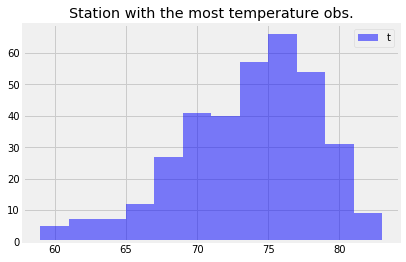

In [26]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
mdatos=pd.DataFrame(session.query(Measurement.date,Measurement.tobs).filter(Measurement.station=='USC00519281').filter(Measurement.date > '2016-08-18').all())
mdatos.head()

x = mdatos.iloc[:,1]
num_bins = 12
n, bins, patches = plt.hist(x, num_bins, facecolor='blue', alpha=0.5)
plt.title('Station with the most temperature obs.')
plt.legend('tobs')
plt.show()

![precipitation](Images/station-histogram.png)

In [27]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.3921568627451, 74.0)]


In [28]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
print(calc_temps(mdatos.loc[0,'date'], mdatos.loc[len(mdatos)-1, 'date']))

[(58.0, 74.49556213017752, 87.0)]


In [29]:
error = max(mdatos.tobs) - min(mdatos.tobs)
x = len(calc_temps(mdatos.loc[0,'date'], mdatos.loc[len(mdatos)-1,'date']))
y = 74.51056511056511

Text(0.5, 1.0, 'Trip Avg Temp')

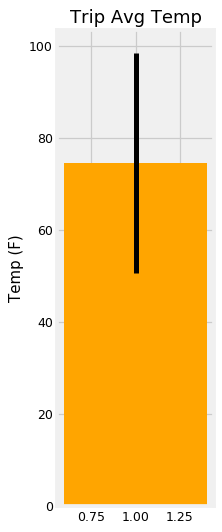

In [30]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
w = 2
h = 7
d = 90
plt.figure(figsize=(w,h), dpi = d)
plt.bar(x,y,color="orange",yerr=error)
plt.ylabel("Temp (F)")
plt.title("Trip Avg Temp")

In [34]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

session.query(Station.station, Station.name,func.sum(Measurement.prcp),Station.latitude, Station.longitude, Station.elevation).filter(Measurement.station == Station.station).group_by(Station.station).order_by(func.sum(Measurement.prcp)).all()

[('USC00517948',
  'PEARL CITY, HI US',
  43.43999999999998,
  21.3934,
  -157.9751,
  11.9),
 ('USC00518838',
  'UPPER WAHIAWA 874.3, HI US',
  70.86999999999999,
  21.4992,
  -158.0111,
  306.6),
 ('USC00511918',
  'HONOLULU OBSERVATORY 702.2, HI US',
  92.67999999999995,
  21.3152,
  -157.9992,
  0.9),
 ('USC00519397',
  'WAIKIKI 717.2, HI US',
  131.61999999999992,
  21.2716,
  -157.8168,
  3.0),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  234.49000000000007,
  21.5213,
  -157.8374,
  7.0),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  295.6800000000001,
  21.33556,
  -157.71139,
  19.5),
 ('USC00513117',
  'KANEOHE 838.1, HI US',
  382.6199999999998,
  21.4234,
  -157.8015,
  14.6),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  588.6400000000001,
  21.45167,
  -157.84888999999998,
  32.9),
 ('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  1068.0899999999997,
  21.3331,
  -157.8025,
  152.4)]

## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


<IPython.core.display.Javascript object>


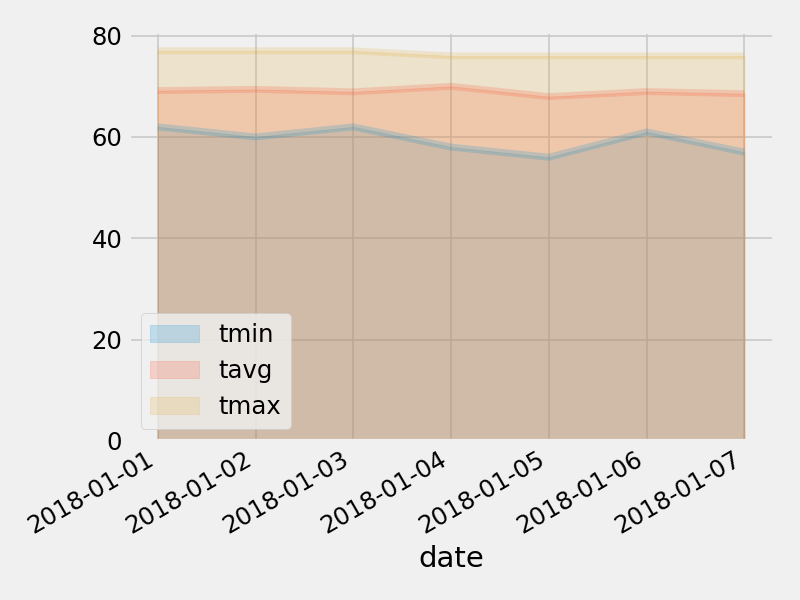

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
